repot root and output folder

In [1]:
import os
from pathlib import Path

HERE = Path.cwd()
if HERE.name == "notebooks":
    os.chdir(HERE.parent)

print("CWD:", Path.cwd())

OUT_DIR = Path("outputs/figures/05_gnn_vs_shuffled")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving to:", OUT_DIR.resolve())

CWD: /Users/samyuktareddy/Desktop/MOF Gas absorption
Saving to: /Users/samyuktareddy/Desktop/MOF Gas absorption/outputs/figures/05_gnn_vs_shuffled


Load GNN summary dicts (REAL + SHUFFLED)

In [2]:
import json
from pathlib import Path

REAL_SUM = Path("outputs/gnn_gcn/threshold_0.10/summary.json")
SHUF_SUM = Path("outputs/gnn_gcn_shuffled/threshold_0.10/summary.json")

real = json.loads(REAL_SUM.read_text()) if REAL_SUM.exists() else None
shuf = json.loads(SHUF_SUM.read_text()) if SHUF_SUM.exists() else None

print("Real summary loaded:", REAL_SUM.exists())
print("Shuffled summary loaded:", SHUF_SUM.exists())

real, shuf

Real summary loaded: True
Shuffled summary loaded: True


({'threshold': 'threshold_0.10',
  'val': {'rmse': {'mean': 0.1546701192855835, 'std': 0.004744128132359363},
   'mae': {'mean': 0.09230821393430233, 'std': 0.004381432634900839},
   'r2': {'mean': -0.27766748840997885, 'std': 0.04044074010973846}},
  'test': {'rmse': {'mean': 0.41565707325935364, 'std': 0.0033747176830219664},
   'mae': {'mean': 0.1594764068722725, 'std': 0.005073562061080934},
   'r2': {'mean': -0.09632082569483125, 'std': 0.017591934241227545}}},
 {'threshold': 'threshold_0.10',
  'val': {'rmse': {'mean': 0.1673777811229229, 'std': 0.021759239261399728},
   'mae': {'mean': 0.10116116888821125, 'std': 0.0177743098328416},
   'r2': {'mean': -0.5074934687001835, 'std': 0.3512593064619777}},
  'test': {'rmse': {'mean': 0.42004356533288956, 'std': 0.014554580174003426},
   'mae': {'mean': 0.15002226829528809, 'std': 0.009805125582368898},
   'r2': {'mean': -0.12083727995225851, 'std': 0.08476860331098465}}})

It defines the two experimental conditions:

Real graph: model sees the true similarity structure.

Shuffled graph: control where structure is destroyed but everything else stays similar.

Load baselines (classical + BH feature)

In [3]:
import json
import pandas as pd
from pathlib import Path

# Classical baselines metrics (Ridge/KNN/RF)
METR_PATH = Path("outputs/baselines/metrics.json")
if not METR_PATH.exists():
    raise FileNotFoundError("Missing outputs/baselines/metrics.json. Run: python src/train_baselines.py")

metrics = json.loads(METR_PATH.read_text())

rows = []
for model_name, m in metrics.items():
    if not isinstance(m, dict): 
        continue
    for split in ["val", "test"]:
        if split in m:
            rows.append({
                "model": model_name.upper(),
                "split": split.upper(),
                "rmse": float(m[split]["rmse"]),
                "mae": float(m[split]["mae"]),
                "r2": float(m[split]["r2"]),
            })

baseline_tab = pd.DataFrame(rows)
display(baseline_tab)

# Best classical baseline on TEST (lowest RMSE)
best_base = baseline_tab[baseline_tab["split"]=="TEST"].sort_values("rmse").iloc[0]
print("Best classical baseline (TEST by RMSE):")
display(best_base)

# BH-feature baseline (across runs)
BH_METR = Path("outputs/baselines_bh_features/per_run_metrics.csv")
if not BH_METR.exists():
    raise FileNotFoundError("Missing outputs/baselines_bh_features/per_run_metrics.csv")

bh = pd.read_csv(BH_METR)
bh_test_mean = float(bh["test_rmse"].mean())
bh_test_std  = float(bh["test_rmse"].std())

print("BH-feature baseline TEST RMSE mean±std:", bh_test_mean, bh_test_std)

,model,split,rmse,mae,r2
0,RIDGE,VAL,0.120002,0.090989,-0.012239
1,RIDGE,TEST,0.437148,0.178250,0.065915
2,KNN,VAL,0.156687,0.079781,-0.725712
3,KNN,TEST,0.408945,0.163669,0.182552
4,RF,VAL,0.141599,0.069065,-0.409369
5,RF,TEST,0.389650,0.146692,0.257871


Best classical baseline (TEST by RMSE):


model          RF
split        TEST
rmse      0.38965
mae      0.146692
r2       0.257871
Name: 5, dtype: object

BH-feature baseline TEST RMSE mean±std: 0.37791771873677543 0.002196117610198003


Establishes non-GNN reference points:

best descriptor-only baseline

graph-derived feature baseline

This prevents the “GNN is impressive” claim from being meaningless.

Build the comparison table (VAL + TEST, mean±std where possible)

In [4]:
import numpy as np
import pandas as pd

def extract_mean_std(block, split):
    return {
        "rmse_mean": block[split]["rmse"]["mean"],
        "rmse_std":  block[split]["rmse"]["std"],
        "mae_mean":  block[split]["mae"]["mean"],
        "mae_std":   block[split]["mae"]["std"],
        "r2_mean":   block[split]["r2"]["mean"],
        "r2_std":    block[split]["r2"]["std"],
    }

rows = []

# Best classical baseline (single result, no std)
rows.append({
    "method": f"Best classical baseline ({best_base['model']})",
    "split": "TEST",
    "rmse_mean": float(best_base["rmse"]), "rmse_std": np.nan,
    "mae_mean": float(best_base["mae"]),   "mae_std": np.nan,
    "r2_mean":  float(best_base["r2"]),    "r2_std":  np.nan,
})

# BH-feature baseline mean±std across runs
rows.append({
    "method": "BH-feature baseline",
    "split": "TEST",
    "rmse_mean": float(bh["test_rmse"].mean()), "rmse_std": float(bh["test_rmse"].std()),
    "mae_mean":  float(bh["test_mae"].mean()),  "mae_std":  float(bh["test_mae"].std()),
    "r2_mean":   float(bh["test_r2"].mean()),   "r2_std":   float(bh["test_r2"].std()),
})

# GNN: real + shuffled, both VAL and TEST
if real is not None:
    for sp in ["val", "test"]:
        rows.append({"method": "GNN (real graph)", "split": sp.upper(), **extract_mean_std(real, sp)})

if shuf is not None:
    for sp in ["val", "test"]:
        rows.append({"method": "GNN (shuffled graph)", "split": sp.upper(), **extract_mean_std(shuf, sp)})

comp = pd.DataFrame(rows)
display(comp)

out_csv = OUT_DIR / "comparison_table_v1.csv"
comp.to_csv(out_csv, index=False)
print("Saved:", out_csv)

,method,split,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
0,Best classical baseline (RF),TEST,0.389650,NaN,0.146692,NaN,0.257871,NaN
1,BH-feature baseline,TEST,0.377918,0.002196,0.125377,0.002759,0.093713,0.013341
2,GNN (real graph),VAL,0.154670,0.004744,0.092308,0.004381,-0.277667,0.040441
3,GNN (real graph),TEST,0.415657,0.003375,0.159476,0.005074,-0.096321,0.017592
4,GNN (shuffled graph),VAL,0.167378,0.021759,0.101161,0.017774,-0.507493,0.351259
5,GNN (shuffled graph),TEST,0.420044,0.014555,0.150022,0.009805,-0.120837,0.084769


Saved: outputs/figures/05_gnn_vs_shuffled/comparison_table_v1.csv


It’s the single place where the reader can compare:

*classical descriptors baseline
*graph-based engineered features
*graph message passing (GNN)
*and a control experiment (shuffled graph)

This table is what you reference in Results as:
“Table X: performance comparison under consistent split protocol.

FIGURE 1: TEST RMSE comparison

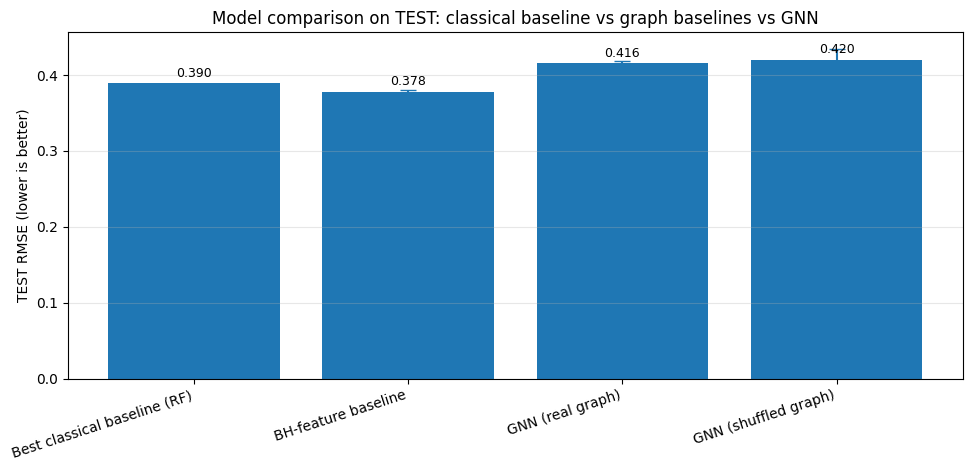

Saved: outputs/figures/05_gnn_vs_shuffled/test_rmse_comparison_v1.png


In [5]:
import matplotlib.pyplot as plt
import numpy as np

test_rows = comp[comp["split"]=="TEST"].copy()

names = test_rows["method"].tolist()
vals  = test_rows["rmse_mean"].astype(float).values
errs  = test_rows["rmse_std"].astype(float).values

plt.figure(figsize=(10, 4.8))
plt.bar(range(len(names)), vals)

# error bars where std exists
for i, (v, e) in enumerate(zip(vals, errs)):
    if not np.isnan(e):
        plt.errorbar([i], [v], yerr=[e], fmt="none", capsize=6)

plt.xticks(range(len(names)), names, rotation=18, ha="right")
plt.ylabel("TEST RMSE (lower is better)")
plt.title("Model comparison on TEST: classical baseline vs graph baselines vs GNN")
plt.grid(True, axis="y", alpha=0.3)

# value labels
for i, v in enumerate(vals):
    plt.text(i, v + max(vals)*0.02, f"{v:.3f}", ha="center", fontsize=9)

out = OUT_DIR / "test_rmse_comparison_v1.png"
plt.tight_layout()
plt.savefig(out, dpi=250)
plt.show()
print("Saved:", out)

Explanation of Figure 1:

What it shows: A direct comparison of generalization error on the test set.

Why: RMSE is the main regression error metric; this summarizes performance clearly.

What conclusion is allowed: which method has lower test error under identical splits.

Important intellectual caution:

If GNN is not better than BH-feature baseline, that still means:

“Graph structure may not add beyond features under current setup.”

That’s not failure—it’s a result.

FIGURE 2: Real vs Shuffled delta (does structure help?)

/var/folders/wv/s2p25mc511x9tt1zdsz1hshr0000gn/T/ipykernel_60858/2536842611.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


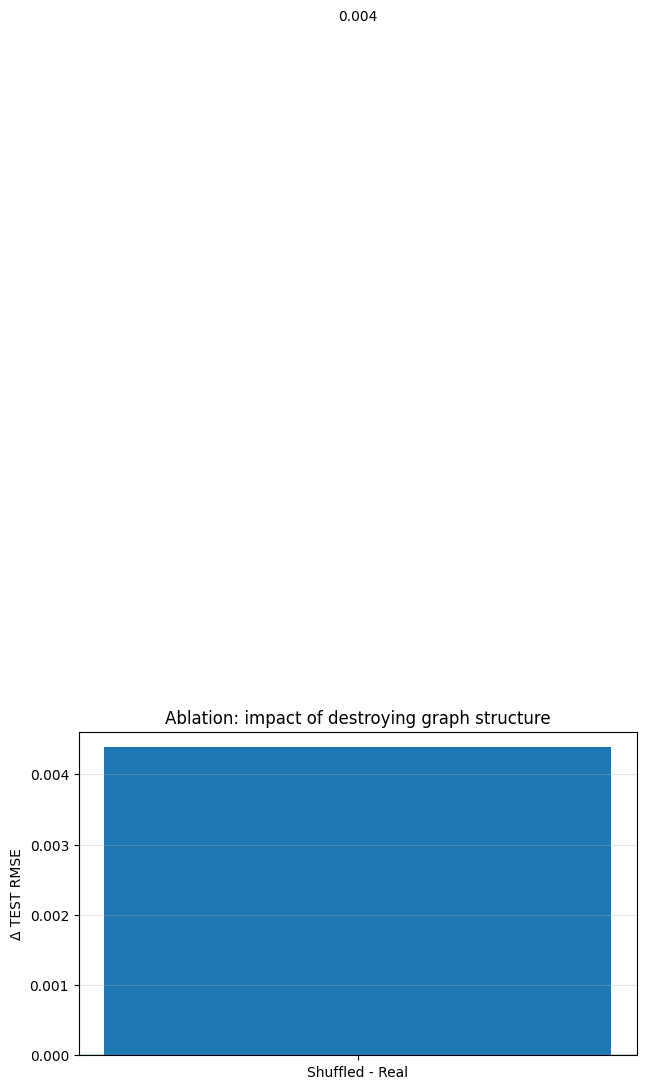

Saved: outputs/figures/05_gnn_vs_shuffled/delta_shuffled_minus_real_test_rmse_v1.png


In [6]:
import matplotlib.pyplot as plt

real_row = comp[(comp["method"]=="GNN (real graph)") & (comp["split"]=="TEST")]
shuf_row = comp[(comp["method"]=="GNN (shuffled graph)") & (comp["split"]=="TEST")]

if len(real_row)==1 and len(shuf_row)==1:
    real_rmse = float(real_row["rmse_mean"].iloc[0])
    shuf_rmse = float(shuf_row["rmse_mean"].iloc[0])
    delta = shuf_rmse - real_rmse  # >0 means shuffled is worse

    plt.figure(figsize=(7.2, 4.2))
    plt.bar(["Shuffled - Real"], [delta])
    plt.axhline(0, linewidth=1)
    plt.ylabel("Δ TEST RMSE")
    plt.title("Ablation: impact of destroying graph structure")
    plt.grid(True, axis="y", alpha=0.3)

    plt.text(0, delta + (abs(delta)*0.08 + 0.01), f"{delta:.3f}", ha="center", fontsize=10)

    out = OUT_DIR / "delta_shuffled_minus_real_test_rmse_v1.png"
    plt.tight_layout()
    plt.savefig(out, dpi=250)
    plt.show()
    print("Saved:", out)
else:
    print("Missing GNN real/shuffled TEST rows in comparison table.")

Explanation of Figure 2

What it shows: how much worse the GNN gets when the graph is randomized.

Why: This isolates whether performance comes from true structure or just model capacity.

Conclusion allowed:

If delta > 0 → real structure helps

If delta ≈ 0 → graph structure isn’t contributing much (yet)

If delta < 0 → your training is unstable or the graph isn’t helpful under this setup

This is a strong scientific control.

In [7]:
real_test = comp[(comp["method"]=="GNN (real graph)") & (comp["split"]=="TEST")]
shuf_test = comp[(comp["method"]=="GNN (shuffled graph)") & (comp["split"]=="TEST")]

txt = []
txt.append("Interpretation stub (edit for thesis):")
txt.append(f"- Best classical baseline (TEST RMSE): {float(best_base['rmse']):.3f}")
txt.append(f"- BH-feature baseline (TEST RMSE mean±std): {float(bh['test_rmse'].mean()):.3f} ± {float(bh['test_rmse'].std()):.3f}")

if len(real_test)==1 and len(shuf_test)==1:
    r = float(real_test["rmse_mean"].iloc[0])
    s = float(shuf_test["rmse_mean"].iloc[0])
    txt.append(f"- GNN real (TEST RMSE mean±std): {r:.3f} ± {float(real_test['rmse_std'].iloc[0]):.3f}")
    txt.append(f"- GNN shuffled (TEST RMSE mean±std): {s:.3f} ± {float(shuf_test['rmse_std'].iloc[0]):.3f}")
    txt.append(f"- Shuffled − Real ΔRMSE: {s - r:.3f} (positive means structure helps)")

print("\n".join(txt))

Interpretation stub (edit for thesis):
- Best classical baseline (TEST RMSE): 0.390
- BH-feature baseline (TEST RMSE mean±std): 0.378 ± 0.002
- GNN real (TEST RMSE mean±std): 0.416 ± 0.003
- GNN shuffled (TEST RMSE mean±std): 0.420 ± 0.015
- Shuffled − Real ΔRMSE: 0.004 (positive means structure helps)
